# Downloading Dataset

In [1]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

--2024-03-03 17:16:52--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [text/plain]
Saving to: ‘airline-passengers.csv.1’

airline-passengers. 100%[===================>]   2.13K  --.-KB/s    in 0s      

2024-03-03 17:16:56 (38.9 MB/s) - ‘airline-passengers.csv.1’ saved [2180/2180]



# Libraries

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import numpy as np

import math
import itertools
from itertools import repeat

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
device

device(type='cuda', index=0)

# Data Plot

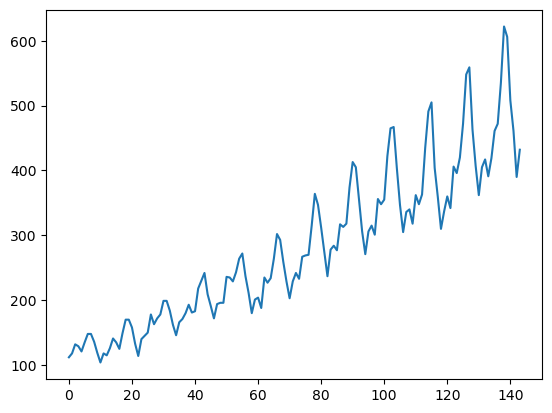

In [12]:
df = pd.read_csv('airline-passengers.csv')
timeseries = df[["Passengers"]].values.astype('float32')

plt.plot(timeseries, label="Airline Passengers")
plt.show()

# Data Loading

In [13]:
def sliding_windows(dataset, lookback):
	X, y = [], []
	for i in range(len(dataset) - lookback):
		X.append(dataset[i:i + lookback])
		y.append(dataset[i + lookback])
	
	return np.array(X), np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(timeseries)

lookback = 4
x, y = sliding_windows(training_data, lookback)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

X_data = torch.tensor(x, dtype=torch.float32).to(device)
y_data = torch.tensor(y, dtype=torch.float32).to(device)

X_train = torch.tensor(x[0:train_size], dtype=torch.float32).to(device)
y_train = torch.tensor(y[0:train_size], dtype=torch.float32).to(device)

X_test = torch.tensor((x[train_size:len(x)]), dtype=torch.float32).to(device)
y_test = torch.tensor((y[train_size:len(y)]), dtype=torch.float32).to(device)

# Utils

In [45]:
def evaluate_model(y_hat, y_true):
	explained_variance = metrics.explained_variance_score(y_true, y_hat)
	mae = metrics.mean_absolute_error(y_true, y_hat)
	mse = metrics.mean_squared_error(y_true, y_hat)
	r2 = metrics.r2_score(y_true, y_hat)
	print('explained_variance_score:%f' % explained_variance)
	print('mae:%f' % mae)
	print('mse:%f' % mse)
	print('rmse:%f' % math.sqrt(mse))
	print('r2:%f' % r2)
	print('---------------------------')

# Model

In [5]:
class RMSELoss(nn.Module):
	def __init__(self):
		super().__init__()
		self.mse = nn.MSELoss()
		
	def forward(self, y_hat, y_true):
		return torch.sqrt(self.mse(y_hat, y_true))


In [6]:
class Model(nn.Module):
	def __init__(self, input_size, hidden_size, num_layers, num_classes):
		super().__init__()

		self.num_layers = num_layers
		self.input_size = input_size
		self.hidden_size = hidden_size
		self.num_classes = num_classes

		self.lstm = nn.LSTM(
			input_size=input_size,
			hidden_size=hidden_size,
			num_layers=num_layers,
			batch_first=True,
		)

		self.fc = nn.Linear(hidden_size, num_classes)
	
	def forward(self, x):
		h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
		c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

		x, _ = self.lstm(x, (h0, c0))
		x = self.fc(x[:, -1, :])

		return x


In [77]:
class EnsembleModel(nn.Module):
	def __init__(self, models = []):
		super().__init__()

		self.models = models
		self.ensemble_models = {}
	
	def add_model(self, model):
		self.models.append(model)

	def ensemble_selection(self, loss_function, y_hats, y_true, init_size=1, max_iter=100):
		losses = {}
		for i, y_hat in enumerate(y_hats):
			losses[i] = loss_function(y_hat, y_true).item()
		
		losses = pd.Series(losses).sort_values()
		init_ensemble = losses.iloc[:init_size].index.to_list()

		if init_size == 1:
			init_loss = losses[0]
			y_hat_avg = y_hats[init_ensemble[0]].clone()
		else:
			y_hat_avg = np.array([y_hat for y_hat in init_ensemble]).mean(axis=0)
			init_loss = loss_function(y_hat_avg, y_true).item()
		
		cur_loss = init_loss
		cur_size = float(init_size)
		
		loss_progress = [cur_loss]
		ensemble_members = [init_ensemble]

		i = 0
		while i < max_iter:
			w_cur = cur_size / (cur_size + 1.0)
			w_new = 1 / (cur_size + 1.0)

			best_loss = float('inf')
			best_y_hat_avg = []
			best_model = -1


			for model, y_hat in enumerate(y_hats):
				tmp_y_hat_avg = y_hat_avg * w_cur + y_hat * w_new
				tmp_loss = loss_function(tmp_y_hat_avg, y_true).item()

				if tmp_loss < best_loss:
					best_loss = tmp_loss
					best_y_hat_avg = tmp_y_hat_avg
					best_model = model

			cur_loss = best_loss
			loss_progress.append(cur_loss)
			y_hat_avg = best_y_hat_avg
			ensemble_members.append(ensemble_members[-1] + [best_model])
			cur_size += 1.0

			i += 1

    # Organize the output
		ensemble_loss = pd.Series(loss_progress, name="loss")
		model_weights = pd.DataFrame(index=ensemble_loss.index)
		for ix, row in model_weights.iterrows():
			weights = pd.Series(ensemble_members[ix]).value_counts()
			weights = weights / weights.sum()
			model_weights.loc[ix, weights.index] = weights

		model_weights = model_weights.fillna(0).astype(float)

		self.ensemble_models = model_weights.iloc[np.argmin(ensemble_loss)].to_dict()

		return ensemble_loss, model_weights

	def state_dict(self, **kwargs):
		models_state_dict = [{'model_state': model.state_dict(),
			'num_classes': model.num_classes,
			'input_size': model.input_size,
			'hidden_size': model.hidden_size,
			'num_layers': model.num_layers} for model in self.models]
		return {
			"models": models_state_dict,
			"ensemble_models": self.ensemble_models,
		}

	def load_state_dict(self, state_dicts, **kwargs):
		models_state_dict = state_dicts['models'] 
		self.ensemble_models = state_dicts['ensemble_models'] 
			
		for model_state in models_state_dict:
			model = Model(model_state['input_size'], model_state['hidden_size'],
										model_state['num_layers'], model_state['num_classes'])
			model.load_state_dict(model_state['model_state'])
			self.models.append(model)

	def forward(self, x):
		res = torch.zeros(x.size(0), 1)
		if len(self.ensemble_models) > 0:
			res = 0
			for i, weight in self.ensemble_models.items():
				res += weight * self.models[i].to(device)(x)
			return res
		else:
			xs = []
			for model in self.models:
				xs.append(model(x))
			return torch.mean(torch.stack(xs), dim=0)

# Setup Models Params

In [206]:
num_classes_range = [1]
input_size_range = [1]
hidden_size_range = [2, 4, 8, 16, 32, 64, 128, 256]
num_layers_range = [1, 2, 3, 4, 5, 6]

# Generate all possible combinations of parameters
models_params = []
for params in itertools.product(num_classes_range, input_size_range, hidden_size_range, num_layers_range):
	model_params = {'num_classes': params[0], 'input_size': params[1], 'hidden_size': params[2], 'num_layers': params[3]}
	models_params.append(model_params)

models_params

[{'num_classes': 1, 'input_size': 1, 'hidden_size': 2, 'num_layers': 1},
 {'num_classes': 1, 'input_size': 1, 'hidden_size': 2, 'num_layers': 2},
 {'num_classes': 1, 'input_size': 1, 'hidden_size': 2, 'num_layers': 3},
 {'num_classes': 1, 'input_size': 1, 'hidden_size': 2, 'num_layers': 4},
 {'num_classes': 1, 'input_size': 1, 'hidden_size': 2, 'num_layers': 5},
 {'num_classes': 1, 'input_size': 1, 'hidden_size': 2, 'num_layers': 6},
 {'num_classes': 1, 'input_size': 1, 'hidden_size': 4, 'num_layers': 1},
 {'num_classes': 1, 'input_size': 1, 'hidden_size': 4, 'num_layers': 2},
 {'num_classes': 1, 'input_size': 1, 'hidden_size': 4, 'num_layers': 3},
 {'num_classes': 1, 'input_size': 1, 'hidden_size': 4, 'num_layers': 4},
 {'num_classes': 1, 'input_size': 1, 'hidden_size': 4, 'num_layers': 5},
 {'num_classes': 1, 'input_size': 1, 'hidden_size': 4, 'num_layers': 6},
 {'num_classes': 1, 'input_size': 1, 'hidden_size': 8, 'num_layers': 1},
 {'num_classes': 1, 'input_size': 1, 'hidden_size':

In [227]:
n_epochs = 5000
learning_rate = 0.001

y_hats = []

ensemble_model = EnsembleModel()

for i, params in enumerate(models_params):
	model = Model(**params).to(device)
	criterion = RMSELoss()
	optimizer = optim.Adam(model.parameters(), lr=learning_rate)

	epoch = 0
	while epoch < n_epochs:
		y_hat = model(X_train)
		optimizer.zero_grad()
  
		loss = criterion(y_hat, y_train)
		loss.backward()
  
		optimizer.step()
		if epoch % 100 == 0:
			print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
		epoch += 1
	
	model.eval()
	with torch.no_grad():
		y_hats.append(model(X_data).cpu())
		ensemble_model.add_model(model)

Epoch: 0, loss: 0.24254
Epoch: 100, loss: 0.13749
Epoch: 200, loss: 0.13084
Epoch: 300, loss: 0.12568
Epoch: 400, loss: 0.11802
Epoch: 500, loss: 0.10283
Epoch: 600, loss: 0.06590
Epoch: 700, loss: 0.05780
Epoch: 800, loss: 0.05649
Epoch: 900, loss: 0.05510
Epoch: 1000, loss: 0.05358
Epoch: 1100, loss: 0.05196
Epoch: 1200, loss: 0.05027
Epoch: 1300, loss: 0.04860
Epoch: 1400, loss: 0.04705
Epoch: 1500, loss: 0.04571
Epoch: 1600, loss: 0.04461
Epoch: 1700, loss: 0.04373
Epoch: 1800, loss: 0.04301
Epoch: 1900, loss: 0.04243
Epoch: 2000, loss: 0.04197
Epoch: 2100, loss: 0.04163
Epoch: 2200, loss: 0.04139
Epoch: 2300, loss: 0.04122
Epoch: 2400, loss: 0.04107
Epoch: 2500, loss: 0.04094
Epoch: 2600, loss: 0.04082
Epoch: 2700, loss: 0.04072
Epoch: 2800, loss: 0.04064
Epoch: 2900, loss: 0.04059
Epoch: 3000, loss: 0.04055
Epoch: 3100, loss: 0.04052
Epoch: 3200, loss: 0.04049
Epoch: 3300, loss: 0.04046
Epoch: 3400, loss: 0.04043
Epoch: 3500, loss: 0.04040
Epoch: 3600, loss: 0.04037
Epoch: 3700, 

In [230]:
ensemble_model.state_dict()

{'models': [{'model_state': OrderedDict([('lstm.weight_ih_l0',
                 tensor([[-0.2990],
                         [ 1.4063],
                         [-1.3244],
                         [ 1.5254],
                         [ 1.4735],
                         [-1.0181],
                         [ 0.9715],
                         [ 1.1219]], device='cuda:0')),
                ('lstm.weight_hh_l0',
                 tensor([[-0.2621, -0.8973],
                         [ 0.1018,  0.4812],
                         [-0.0635,  0.1960],
                         [ 1.3377,  3.2719],
                         [-1.4443,  0.9672],
                         [-0.5894,  0.0715],
                         [-0.1952, -0.4943],
                         [ 0.8349,  0.9190]], device='cuda:0')),
                ('lstm.bias_ih_l0',
                 tensor([ 0.4746,  0.5932, -0.5724, -0.1024, -0.3312,  0.7735, -0.1132,  0.8454],
                        device='cuda:0')),
                ('lstm.bias_hh_l0'

In [229]:
torch.save(ensemble_model.state_dict(), 'air_model.pth')

In [84]:
air_model = EnsembleModel()
air_model.load_state_dict(torch.load('air_model.pth'))

In [ ]:
y_hats = []
for model in air_model.models:
	model = model.to(device)
	model.eval()
	with torch.no_grad():
		y_hats.append(model(X_data).cpu())

In [79]:
critertion = RMSELoss()
ensemble_loss, model_weights = air_model.ensemble_selection(critertion, y_hats, y_data.cpu())

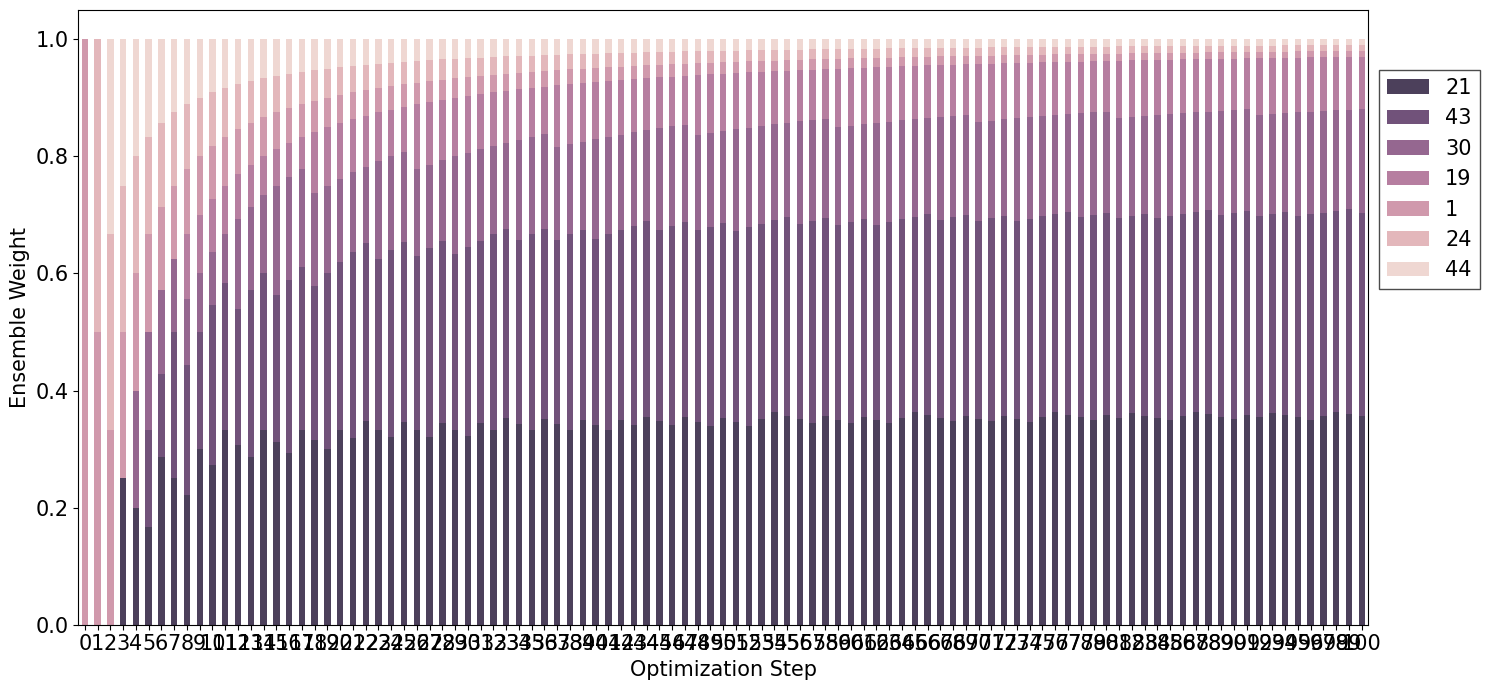

In [74]:
# Locate non-zero weights and sort models by their average weight
weights_to_plot = model_weights.loc[:, (model_weights != 0).any()]
weights_to_plot = weights_to_plot[
		weights_to_plot.mean().sort_values(ascending=False).index]

# A palette corresponding to the number of models with non-zero weights
palette = sns.cubehelix_palette(weights_to_plot.shape[1], reverse=True)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
weights_to_plot.plot(kind="bar", stacked=True, color=palette, ax=ax,
											alpha=0.85)

ax.margins(x=0.0)
ax.set_xlabel("Optimization Step", fontsize=15, visible=True)
ax.set_ylabel("Ensemble Weight", fontsize=15, visible=True)
ax.yaxis.set_tick_params(rotation=0, labelsize=15)
ax.xaxis.set_tick_params(rotation=0, labelsize=15)
ax.legend(loc="best", bbox_to_anchor=(1, 0.92),
					frameon=True, edgecolor="k", fancybox=False,
					framealpha=0.7, shadow=False, ncol=1, fontsize=15)
fig.tight_layout()

In [85]:
ensemble_pred = air_model(X_data)

explained_variance_score:0.735577
mae:0.057268
mse:0.004573
rmse:0.067627
r2:0.720957
---------------------------


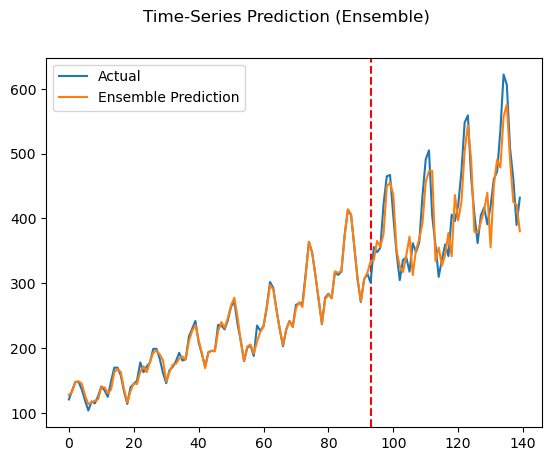

In [87]:
y_plot = sc.inverse_transform(y_data.cpu())
y_hat = sc.inverse_transform(ensemble_pred.data.cpu().numpy())

evaluate_model(y_test.cpu(), ensemble_pred.data[train_size:].cpu())

# Plotting
plt.axvline(x=train_size, c='r', linestyle='--')
plt.plot(y_plot, label='Actual')
plt.plot(y_hat, label='Ensemble Prediction')
plt.suptitle('Time-Series Prediction (Ensemble)')
plt.legend()
plt.show()